<a href="https://colab.research.google.com/github/btran30/cs584/blob/brenda/Densenet201_pretrained.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DenseNet 201 Analysis

## Library Import

In [4]:
import tensorflow 
from numpy.random import seed
seed(1)
tensorflow.random.set_seed(2)

In [5]:
import tensorflow 
import pandas as pd
import numpy as np
import os
import keras
import matplotlib.pyplot as plt
import time

from tensorflow.keras.datasets import cifar100, cifar10
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D,Convolution2D,BatchNormalization,Activation,Flatten,MaxPooling2D,Dropout,UpSampling2D
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

import warnings
warnings.filterwarnings("ignore")

print("Tensorflow-version:", tensorflow.__version__)

Tensorflow-version: 2.3.0


## Load and preprocess Data from Keras

In [6]:
def preprocess_data(num_classes):

    if num_classes == 100:
        (x_train, y_train), (x_test, y_test) = cifar100.load_data()
    else :
        (x_train, y_train), (x_test, y_test) = cifar10.load_data()
        
    x_train = tensorflow.keras.applications.densenet.preprocess_input(x_train)
    x_test = tensorflow.keras.applications.densenet.preprocess_input(x_test)
    y_train = tensorflow.keras.utils.to_categorical(y_train)
    y_test = tensorflow.keras.utils.to_categorical(y_test)
       
    print('Train: X=%s, y=%s' % (x_train.shape, y_train.shape))
    print('Test: X=%s, y=%s' % (x_test.shape, y_test.shape))
    return (x_train, y_train), (x_test, y_test) 

## DenseNet 201 Model

We utilize ImageDataGenerator to augment our input data.  This should help us avoid overfitting.

In [7]:
def fit_model(num_classes, x_train, y_train, x_test, y_test):
    densenet_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    for layer in densenet_model.layers:
      if isinstance(layer, BatchNormalization):
        layer.trainable = True  # update the weight
      else:
        layer.trainable = False
        
    model = Sequential()
    model.add(UpSampling2D(size=(7,7)))
    model.add(densenet_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(.25))
    model.add(BatchNormalization())
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy', 'top_k_categorical_accuracy'])

    datagen = ImageDataGenerator(rotation_range=8,
                             shear_range=0.2, 
                             zoom_range=0.2,
                             channel_shift_range=0.05, 
                             horizontal_flip=True)
    datagen.fit(x_train)
    # Fits-the-model
    batch_size = 64
    epochs = 10
    anne = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=5, verbose=1, min_lr=1e-3)
    checkpoint = ModelCheckpoint('Densenet201_cifar'+str(num_classes)+'.h5', verbose=1, save_best_only=True)

    t=time.time()
    history = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
               steps_per_epoch=x_train.shape[0] // batch_size,
               epochs=epochs,
               verbose=1,
               callbacks=[anne,checkpoint],
               validation_data=(x_test, y_test))
    print('Training time: %s' % (time.time() -t))
    return history, model

In [8]:
def summarize_diagnostics(num_classes, history):
    cifar = 'CIFAR'+str(num_classes)
    plt.subplots_adjust(hspace=0.7)
    # plot loss
    plt.subplot(211)
    plt.title(cifar + ' Cross Entropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='test')
    
    # plot accuracy
    plt.subplot(212)
    plt.title(cifar + ' Classification Accuracy')
    plt.plot(history.history['accuracy'], color='blue', label='train')
    plt.plot(history.history['val_accuracy'], color='orange', label='test')
    
    # save plot to file
    #filename = "DenseNet201_Pretrained"
    #plt.savefig(filename + '_plot.png')
    
    return history


In [9]:
def predict(model, x_test, y_test):
    ypred = model.predict(x_test)

    total = 0
    accurate = 0
    accurateindex = []
    wrongindex = []

    for i in range(len(ypred)):
        if np.argmax(ypred[i]) == np.argmax(y_test[i]):
            accurate += 1
            accurateindex.append(i)
        else:
            wrongindex.append(i)

        total += 1
    
    print('Total-test-data;', total, '\taccurately-predicted-data:', accurate, '\t wrongly-predicted-data: ', total - accurate)
    print('Accuracy:', round(accurate/total*100, 3), '%')
    return ypred

### Run with CIFAR100

169009152/169001437 [==============================] - 4s 0us/step
Train: X=(50000, 32, 32, 3), y=(50000, 100)
Test: X=(10000, 32, 32, 3), y=(10000, 100)
74842112/74836368 [==============================] - 0s 0us/step
Epoch 1/10
781/781 [==============================] - ETA: 0s - loss: 1.6750 - accuracy: 0.5635 - top_k_categorical_accuracy: 0.8292
Epoch 00001: val_loss improved from inf to 0.98312, saving model to Densenet201_cifar100.h5
781/781 [==============================] - 703s 901ms/step - loss: 1.6750 - accuracy: 0.5635 - top_k_categorical_accuracy: 0.8292 - val_loss: 0.9831 - val_accuracy: 0.7187 - val_top_k_categorical_accuracy: 0.9375
Epoch 2/10
781/781 [==============================] - ETA: 0s - loss: 0.9360 - accuracy: 0.7249 - top_k_categorical_accuracy: 0.9433
Epoch 00002: val_loss improved from 0.98312 to 0.80190, saving model to Densenet201_cifar100.h5
781/781 [==============================] - 699s 896ms/step - loss: 0.9360 - accuracy: 0.7249 - top_k_categorical_a

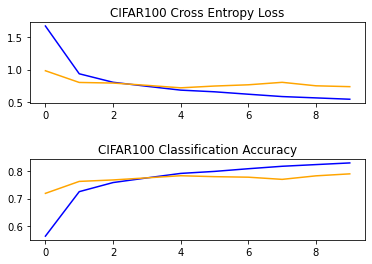

In [10]:
num_classes = 100
(x_train, y_train), (x_test, y_test) = preprocess_data(num_classes)
history, model = fit_model(num_classes, x_train, y_train,x_test, y_test)
print('\n\n')
summarize_diagnostics(num_classes, history)
print('\n')
pred = predict(model, x_test, y_test)

### Run with CIFAR10

170500096/170498071 [==============================] - 2s 0us/step
Train: X=(50000, 32, 32, 3), y=(50000, 10)
Test: X=(10000, 32, 32, 3), y=(10000, 10)
Epoch 1/10
781/781 [==============================] - ETA: 0s - loss: 0.3769 - accuracy: 0.8718 - top_k_categorical_accuracy: 0.9914
Epoch 00001: val_loss improved from inf to 0.21007, saving model to Densenet201_cifar10.h5
781/781 [==============================] - 695s 889ms/step - loss: 0.3769 - accuracy: 0.8718 - top_k_categorical_accuracy: 0.9914 - val_loss: 0.2101 - val_accuracy: 0.9322 - val_top_k_categorical_accuracy: 0.9978
Epoch 2/10
781/781 [==============================] - ETA: 0s - loss: 0.1937 - accuracy: 0.9349 - top_k_categorical_accuracy: 0.9987
Epoch 00002: val_loss improved from 0.21007 to 0.16300, saving model to Densenet201_cifar10.h5
781/781 [==============================] - 692s 885ms/step - loss: 0.1937 - accuracy: 0.9349 - top_k_categorical_accuracy: 0.9987 - val_loss: 0.1630 - val_accuracy: 0.9461 - val_top_k

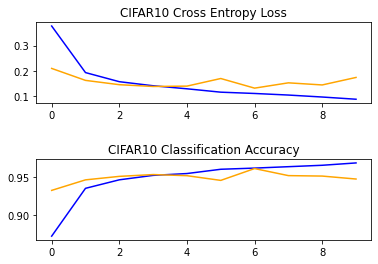

In [ ]:
num_classes = 10
(x_train, y_train), (x_test, y_test) = preprocess_data(num_classes)
history, model = fit_model(num_classes, x_train, y_train,x_test, y_test)
print('\n\n')
summarize_diagnostics(num_classes, history)
print('\n')
pred = predict(model, x_test, y_test)